In [15]:
import warnings
warnings.filterwarnings ('ignore')

In [16]:
!pip install tensorflow rdkit networkx

  Using cached rdkit-2024.3.5-cp39-cp39-win_amd64.whl (21.7 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'C:\\Users\\Meganet\\anaconda3\\Lib\\site-packages\\rdkit\\rdBase.pyd'
Consider using the `--user` option or check the permissions.



In [17]:
import tensorflow as tf
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.rdmolops import GetAdjacencyMatrix

Colonnes disponibles : Index(['Mutation', 'SMILES'], dtype='object')


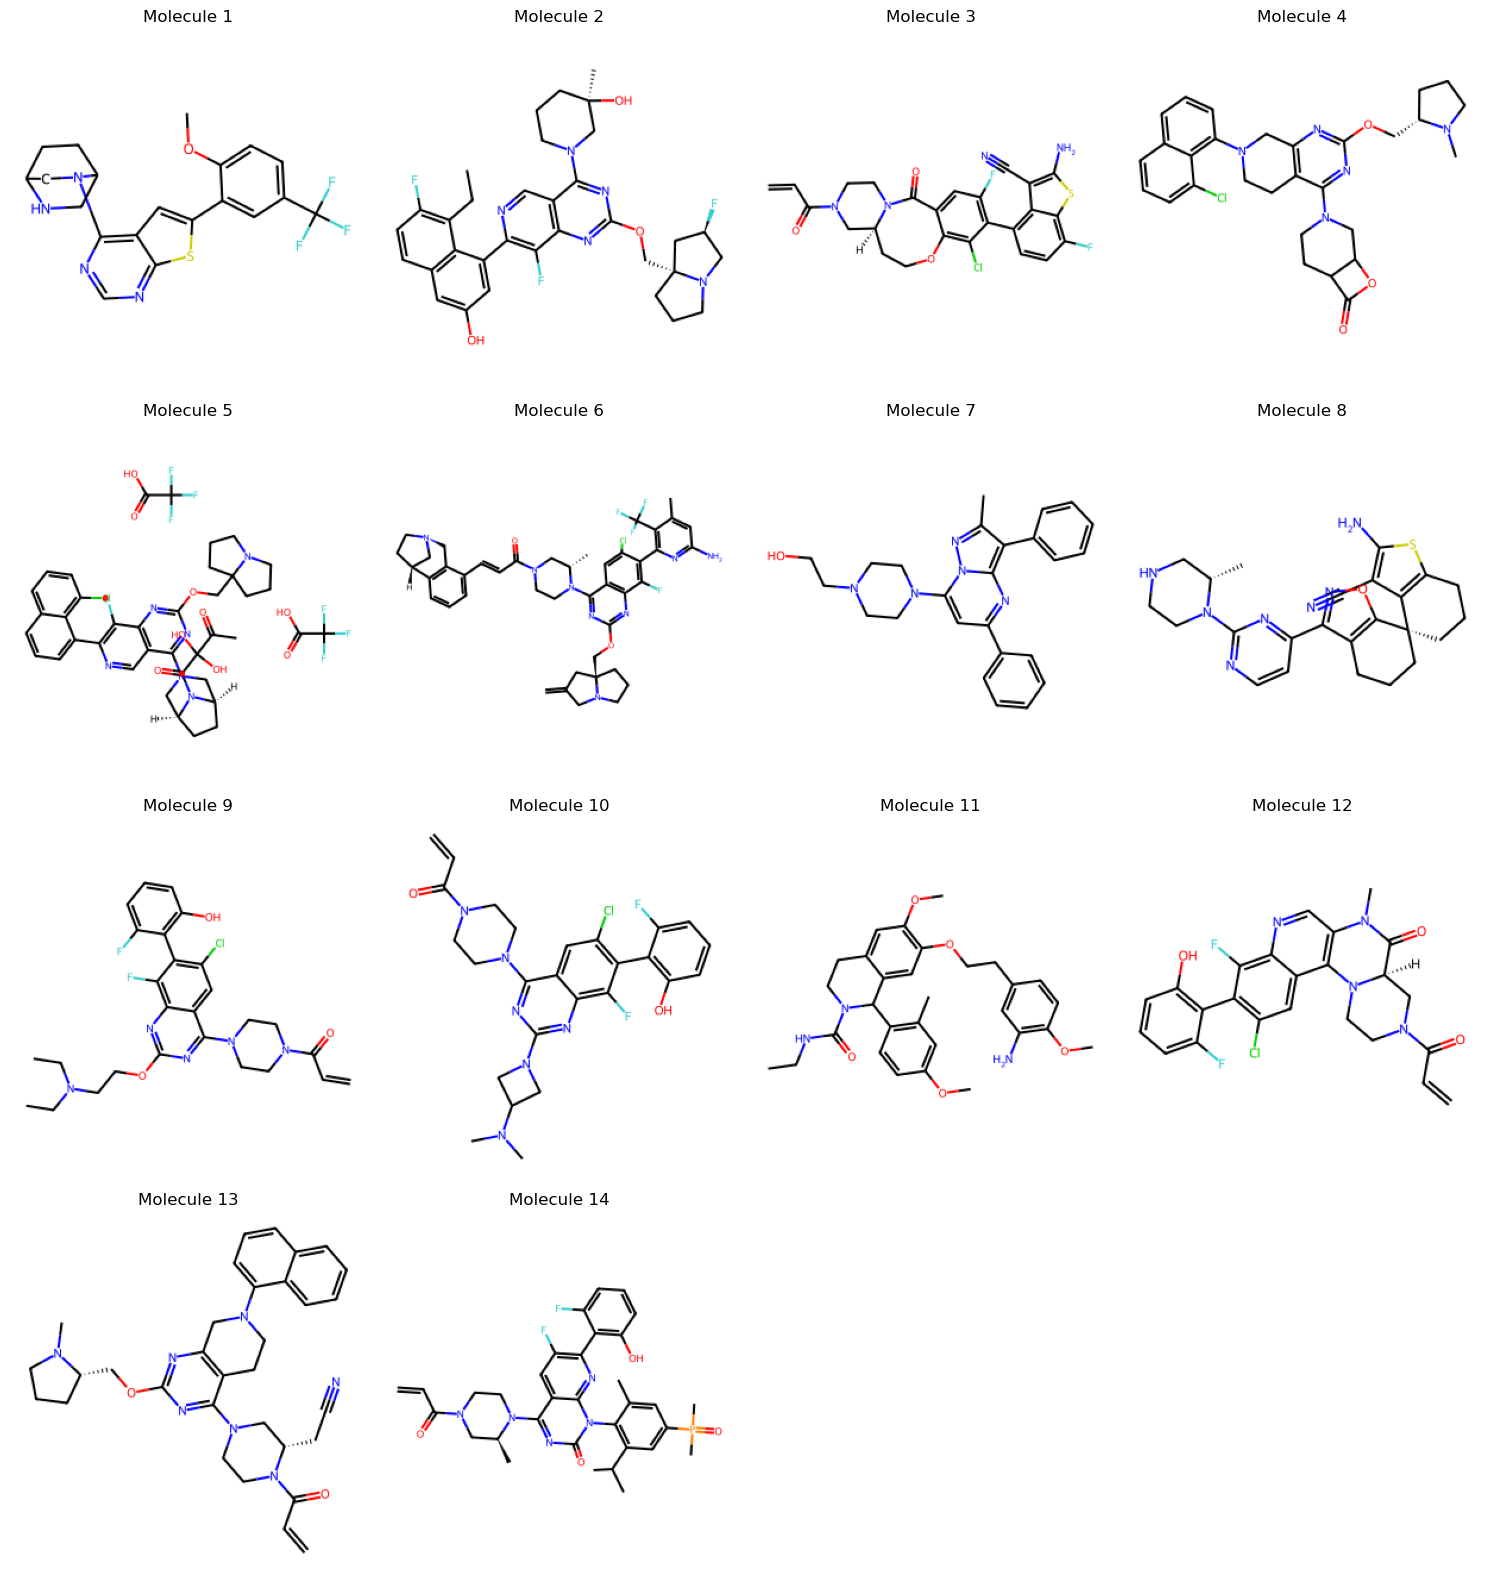

In [14]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

# Charger le fichier CSV 
file_path = r"C:\Users\Meganet\Desktop\KRAS_SMILES.csv"

# Gestion des erreurs lors de la lecture du fichier CSV
try:
    data = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1')
except Exception as e:
    print(f"Erreur lors de la lecture du fichier CSV : {e}")
    raise

# Afficher les colonnes du DataFrame
print("Colonnes disponibles :", data.columns)

# Supposons que la colonne contenant les SMILES s'appelle 'SMILES'
smiles_column_name = 'SMILES'

# Vérifiez si la colonne existe
if smiles_column_name in data.columns:
    # Convertir la colonne SMILES en liste 
    smiles_list = data[smiles_column_name].astype(str).tolist()

    # Créer des objets moléculaires à partir des chaînes SMILES
    molecules = [Chem.MolFromSmiles(smile) for smile in smiles_list]

    # Filtrer les molécules valides
    valid_molecules = [mol for mol in molecules if mol is not None]

    # Configuration de la figure pour afficher les molécules
    n_cols = 4  # Nombre de colonnes pour l'affichage
    n_rows = (len(valid_molecules) + n_cols - 1) // n_cols  # Calculer le nombre de lignes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))  # Ajustez la taille selon le besoin

    # Afficher les images des molécules
    for i, mol in enumerate(valid_molecules):
        ax = axes[i // n_cols, i % n_cols]  # Obtenir l'axe approprié
        img = Draw.MolToImage(mol)
        ax.imshow(img)
        ax.set_title(f"Molecule {i + 1}")
        ax.axis('off')  # Masquer les axes

    # Masquer les axes vides si le nombre de molécules n'est pas un multiple de n_cols
    for j in range(len(valid_molecules), n_rows * n_cols):
        axes[j // n_cols, j % n_cols].axis('off')

    # Ajuster l'affichage
    plt.tight_layout()
    plt.show()  # Afficher toutes les images à la fois
else:
    print(f"La colonne '{smiles_column_name}' n'existe pas dans le DataFrame.")


# GAN

In [40]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras import Model

# Load and preprocess real SMILES data
def load_and_preprocess_smiles(file_path, batch_size=64):
    # Load SMILES data from CSV with a specified encoding
    smiles_data = pd.read_csv(file_path, encoding='ISO-8859-1')  # Use ISO-8859-1 encoding

    # Print the columns of the DataFrame for debugging
    print("Columns in the DataFrame:", smiles_data.columns.tolist())

    # Trim whitespace from column names
    smiles_data.columns = smiles_data.columns.str.strip()

    # Use the correct column name for SMILES
    smiles_column_name = 'Mutation;SMILES'

    # Check if the column exists
    if smiles_column_name not in smiles_data.columns:
        raise KeyError(f"'{smiles_column_name}' column not found in the CSV file. Available columns: " + str(smiles_data.columns))

    # Assuming the column with SMILES is named 'Mutation;SMILES'
    smiles_array = smiles_data[smiles_column_name].values

    # Vectorization or encoding of SMILES would go here.
    # For demonstration purposes, we will use a dummy representation.
    # Replace this with your actual encoding logic for SMILES
    vectorized_smiles = np.random.rand(len(smiles_array), 1)  # Dummy vectorization (replace with actual)

    indices = np.random.choice(vectorized_smiles.shape[0], batch_size, replace=False)
    return vectorized_smiles[indices]  # Return a batch of real SMILES

# Define the dimensions
latent_dim = 100  # Dimension of the noise vector

# Create the generator model
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for SMILES
    return model

# Create the discriminator model
def build_discriminator():
    model = Sequential()
    model.add(Dense(512, input_dim=1, activation='relu'))  # Assuming input SMILES is vectorized
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    return model

# Function to train the GAN
def train_gan(epochs, batch_size, file_path):
    generator = build_generator()
    discriminator = build_discriminator()

    # Compile the discriminator
    discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

    # Create the GAN model
    z = Input(shape=(latent_dim,))
    generated_smiles = generator(z)
    discriminator_output = discriminator(generated_smiles)
    gan = Model(z, discriminator_output)

    # Compile the GAN
    gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

    for epoch in range(epochs):
        # Generate random noise
        noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
        
        # Generate fake SMILES
        generated_smiles = generator.predict(noise)

        # Get a batch of real SMILES data
        real_smiles = load_and_preprocess_smiles(file_path, batch_size=batch_size)
        
        # Combine real and fake SMILES
        combined_smiles = np.concatenate([real_smiles, generated_smiles])
        
        # Labels for real and fake
        labels = np.array([1] * batch_size + [0] * batch_size, dtype=int)  # 1 for real, 0 for fake

        # Train the discriminator
        discriminator.trainable = True
        d_loss = discriminator.train_on_batch(combined_smiles, labels)

        # Train the generator
        noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
        labels = np.array([1] * batch_size, dtype=int)  # Wants the generator to fool the discriminator
        discriminator.trainable = False
        g_loss = gan.train_on_batch(noise, labels)

        # Print the losses
        print(f"Epoch {epoch + 1}/{epochs}, Discriminator Loss: {d_loss[0]:.4f}, Generator Loss: {g_loss:.4f}")

# Function to generate new SMILES
def generate_smiles(generator, num_samples):
    noise = np.random.normal(0, 1, size=[num_samples, latent_dim])
    generated_smiles = generator.predict(noise)
    return generated_smiles  # Convert generated outputs back to SMILES format if needed

# Set parameters for training
num_epochs = 1000  # Specify the number of epochs
batch_size = 14     # Specify the batch size
file_path = r"C:\Users\Meganet\Desktop\KRAS_SMILES.csv"  # Your CSV file path

# Train the GAN
train_gan(num_epochs, batch_size, file_path)

# Generate new SMILES after training
num_samples = 5  # Specify how many samples you want to generate
generator = build_generator()  # Rebuild the generator to get the trained weights
generated_smiles = generate_smiles(generator, num_samples)

# Print generated SMILES (you may need to decode based on your encoding strategy)
print("Generated SMILES:", generated_smiles)


1/1 [==============================] - 0s 62ms/step
Columns in the DataFrame: ['Mutation;SMILES']
Epoch 1/1000, Discriminator Loss: 0.6948, Generator Loss: 0.6836
1/1 [==============================] - 0s 24ms/step
Columns in the DataFrame: ['Mutation;SMILES']
Epoch 2/1000, Discriminator Loss: 0.6936, Generator Loss: 0.6800
1/1 [==============================] - 0s 27ms/step
Columns in the DataFrame: ['Mutation;SMILES']
Epoch 3/1000, Discriminator Loss: 0.6966, Generator Loss: 0.6772
1/1 [==============================] - 0s 26ms/step
Columns in the DataFrame: ['Mutation;SMILES']
Epoch 4/1000, Discriminator Loss: 0.6975, Generator Loss: 0.6763
1/1 [==============================] - 0s 27ms/step
Columns in the DataFrame: ['Mutation;SMILES']
Epoch 5/1000, Discriminator Loss: 0.6988, Generator Loss: 0.6766
1/1 [==============================] - 0s 46ms/step
Columns in the DataFrame: ['Mutation;SMILES']
Epoch 6/1000, Discriminator Loss: 0.7013, Generator Loss: 0.6783
1/1 [=================

# SMILES (Simplified Molecular Input Line Entry System) est une notation qui encode la structure d'un composé chimique dans un format texte. Chaque chaîne SMILES représente une structure moléculaire unique.